In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pyTEMlib
from pyTEMlib import file_tools as ft
from pyTEMlib import image_tools as it
%matplotlib ipympl

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Qt dialogs are not available


In [2]:
print(pyTEMlib.__version__)

0.2024.02.2


In [3]:
# Graphene exp data
path = '/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/'
files = os.listdir(path)
files = [f for f in files if f.endswith('.emd')]

In [4]:
dates = [file.split(' ')[2].split('_')[0] for file in files]
dates = list(set(dates))

date = dates[0]
sorted_files = [file for file in files if '.emd' in file]

for file in sorted_files:
    print(path+file)

# file indexes 2,8,14 on dates[4] are Moires

/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/0046 - 20240404_STEM_3.85_nm.emd
/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/0052 - 20231205_1829_STEM_3.85_nm_HAADF.emd
/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/0049 - 20240404_STEM_3.85_nm.emd
/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/0053 - 20231205_1836_STEM_3.85_nm_HAADF.emd
/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/0045 - 20231205_1739_STEM_5.44_nm_HAADF.emd
/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/0036 - 20231205_1655_STEM_3.85_nm_HAADF.emd
/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/0107 - 20231206_1908_STEM_7.69_nm_HAADF.emd
/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/0041 - 20231205_1724_STEM_5.44_nm_HAADF.emd
/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/0023 - 20231205_1505_STEM_3.85_nm_HAADF.emd
/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/0047 - 20240404_STEM_3.85_nm.emd
/Users/austin/Dropbox/graphene_images/Hao_Wang_colab/0034 - 202

In [14]:
file

'0043 - 20231205_1735_STEM_5.44_nm_HAADF.emd'

Pixel size:  1.062231596676198e-11


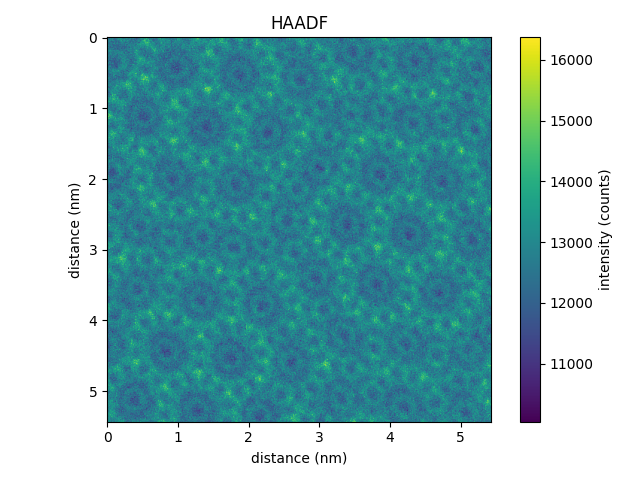

In [13]:
file = sorted_files[14]

dset = ft.open_file(path + file)
image = dset['Channel_000']
viw = image.plot()

pixel_size = image.original_metadata['BinaryResult']['PixelSize']['width']
pixel_size = np.array(pixel_size)
print('Pixel size: ', pixel_size, )

In [33]:
im_array = np.array(image)

np.savez('moire.npz', im_array=im_array, pixel_size=pixel_size)

Pixel size:  0.2124463193352398  Angstroms/pixel


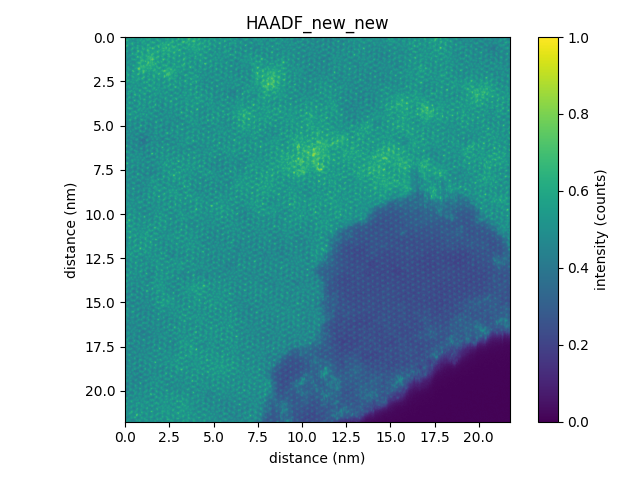

In [13]:
# WSSe Exp data 
# path = '/Users/austin/Desktop/Projects/WS2_twist/WS2_1deg/20230315/WS2_1deg/20230315 1045 STEM HAADF 9.20 Mx.emd'
path = '/Users/austin/Desktop/Projects/WS2_twist/WS2_15deg/20230303/20230303 1703 STEM HAADF 4.60 Mx.emd'
dset = ft.open_file(path)
image = dset['Channel_000']

# normalize the image
image = image - image.min()
image = image/image.max()
im_array = np.array(image)


view = image.plot()

pixel_size = dset['Channel_000'].original_metadata['BinaryResult']['PixelSize']['width'] # m/pixel
pixel_size = float(pixel_size) * 1e10 # Angstrom/pixel

print('Pixel size: ', pixel_size, ' Angstroms/pixel')

In [14]:
# scipy ndimage zoom to get the right pixel size
from scipy.ndimage import zoom

zoom_factor = 2
zoomed_im = zoom(im_array, zoom_factor, order=3)
pixel_size = pixel_size / zoom_factor

In [15]:
pixel_size

0.1062231596676199

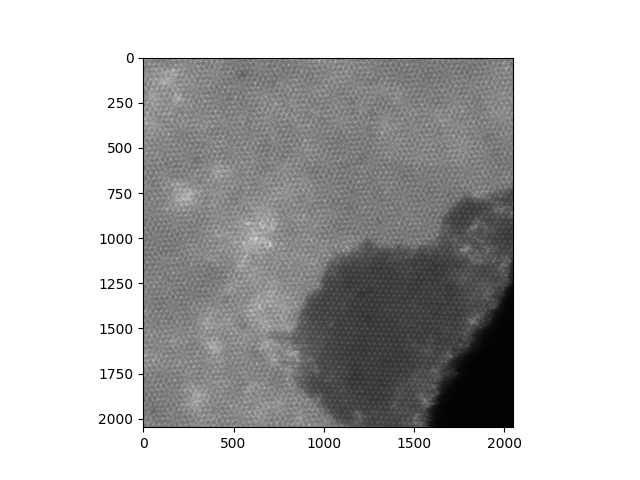

In [16]:
plt.figure()
plt.imshow(zoomed_im, cmap='gray')

Stack contains  20  images, each with 1024  pixels in x-direction and  1024  pixels in y-direction


  0%|          | 0/20 [00:00<?, ?it/s]

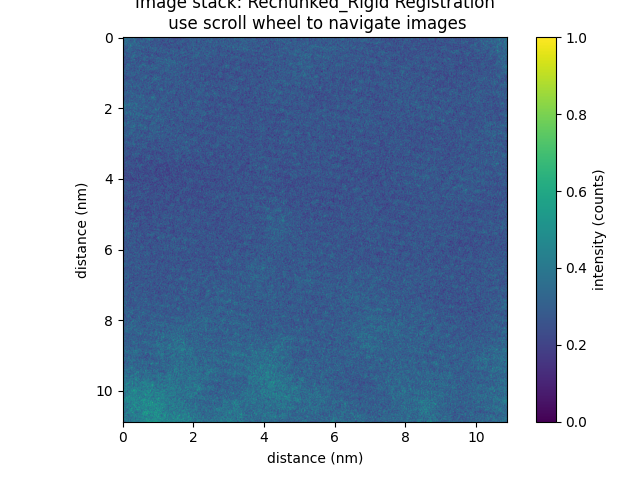

In [4]:
rigid_registered_dataset = it.rigid_registration(image)
view = rigid_registered_dataset.plot()
    

In [8]:
im_array = np.array(rigid_registered_dataset).sum(axis=0)
im_array.shape

(1024, 1024)

In [17]:
# im_array = np.array(rigid_registered_dataset).sum(axis=0)

np.savez('WSSe_haadf_2.npz', im_array=zoomed_im, pixel_size=pixel_size)

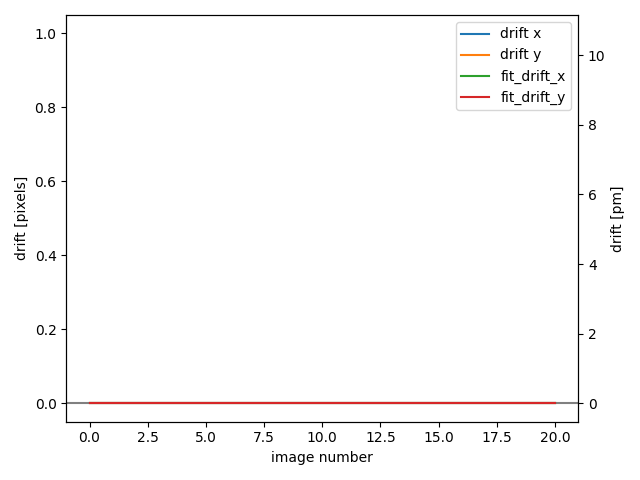

In [5]:
drift = rigid_registered_dataset.metadata['drift']
polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...

x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)

plt.figure()
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')

plt.legend();
ax_pixels = plt.gca()
ax_pixels.step(1, 1)

scaleX = (rigid_registered_dataset.x[1]-rigid_registered_dataset.x[0])*1000.  #in pm

ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()

ax_pm.set_ylim(x_1*scaleX, x_2*scaleX)

ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()

In [6]:
# non_rigid_registered = it.demon_registration(rigid_registered_dataset)

This feature is not available: 
 Please install simpleITK with: conda install simpleitk -c simpleitk


AttributeError: 'bool' object has no attribute 'GetImageFromArray'

## get some more images of WSSe


In [ ]:
# WSSe Exp data 
path = '/Users/austin/Desktop/Projects/WS2_twist/WS2_1deg/20230315/WS2_1deg/20230315 1045 STEM HAADF 9.20 Mx.emd'
dset = ft.open_file(path)
image = dset['Channel_000']

# normalize the image
image = image - image.min()
image = image/image.max()
im_array = np.array(image)


view = image.plot()

pixel_size = dset['Channel_000'].original_metadata['BinaryResult']['PixelSize']['width'] # m/pixel
pixel_size = float(pixel_size) * 1e10 # Angstrom/pixel

print('Pixel size: ', pixel_size, ' Angstroms/pixel')

im_array = np.array(rigid_registered_dataset)

np.savez('WSSe_haadf.npz', im_array=im_array, pixel_size=pixel_size)